In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

## Alpha solve

In [535]:
def calculate_K(N):
    K = 0
    prod = 0
    while prod < N:
        K += 1
        prod = (2 * K + 1)**2
    return K

def construct_fourier_matrices(K, points, num_bulk_Vs):

    fourier_modes = [(k1, k2) for k1 in range(-K, K + 1) for k2 in range(-K, K + 1)]
    M = len(fourier_modes)

    bulk_V_coords = points[:num_bulk_Vs]
    boundary_V_coords = points[num_bulk_Vs:]
    num_boundary_Vs = np.shape(boundary_V_coords)[0]

    # Construct Fourier matrix F_1 for points_f1
    F_1 = np.zeros((num_bulk_Vs, M), dtype=complex)
    for en, (x_i, y_i) in enumerate(bulk_V_coords):
        for j, (k1, k2) in enumerate(fourier_modes):
            F_1[en, j] = np.exp(2 * np.pi * 1j * (k1 * x_i + k2 * y_i))

    # Construct Fourier matrix F_2 for points_f2
    F_2 = np.zeros((num_boundary_Vs, M), dtype=complex)
    for en, (x_i, y_i) in enumerate(boundary_V_coords):
        for j, (k1, k2) in enumerate(fourier_modes):
            F_2[en, j] = np.exp(2 * np.pi * 1j * (k1 * x_i + k2 * y_i))

    return F_1, F_2

def direct_solve_alpha(g, half_num_fourier_modes_per_dim, regularization=False):
    """g needs:
    num_bulk_Vs
    wlaplacian
    V_coords
    r
    """
    F_1, F_2 = construct_fourier_matrices(half_num_fourier_modes_per_dim, g.V_coords, g.num_bulk_Vs)

    A = g.wlaplacian[:g.num_bulk_Vs, :g.num_bulk_Vs]
    B = g.wlaplacian[:g.num_bulk_Vs, g.num_bulk_Vs:] 
    r = g.r.copy()

    LHS = A @ F_1 + B @ F_2
    RHS = r

    # Solve the system
    U, S, Vt = np.linalg.svd(LHS, full_matrices=False)
    threshold = 0.1 * S.max() 
    S_filtered = np.diag(S * (S > threshold))
    LHS = U @ S_filtered @ Vt

    print(f"Doing least squares")
    fourier_coefficients, _, _, _ = np.linalg.lstsq(LHS, RHS, rcond=None)
    print(f"err = {np.linalg.norm(LHS @ fourier_coefficients - RHS)}")

    # Extract the values of f_1 and c
    alpha_bulk = (F_1 @ fourier_coefficients).real
    alpha_boundary = (F_2 @ fourier_coefficients).real

    return alpha_bulk, alpha_boundary, fourier_coefficients, F_1, F_2

## Delaunay triangulation

In [246]:
class Delaunay_Torus:

    def __init__(self, N, figsize=5, plot_V_num=False):

        self.construct_V_coords(N)
        self.construct_solve_data()
        self.plot_graph(figsize=figsize, plot_V_num=plot_V_num)

    def construct_V_coords(self, N):

        all_V_coords = np.random.uniform(-1, 2, size=(N, 2))

        # Partition into bulk and boundary indices
        bulk_V_coord_inds = []
        boundary_V_coord_inds = []
        for en, (x, y) in enumerate(all_V_coords):
            if (0 <= x <= 1) and (0 <= y <= 1):
                bulk_V_coord_inds.append(en)
            else:
                boundary_V_coord_inds.append(en)

        # Construct bulk and boundary V_coords and reorder in all_V_coords
        bulk_V_coords = all_V_coords[bulk_V_coord_inds]
        boundary_V_coords = all_V_coords[boundary_V_coord_inds]
        num_bulk_Vs = len(bulk_V_coord_inds)
        all_V_coords = np.vstack((bulk_V_coords, boundary_V_coords))

        # Triangulate
        triangulation = scipy.spatial.Delaunay(all_V_coords)

        # Construct edges
        V, W = triangulation.vertex_neighbor_vertices 
        bulk_edges = []
        boundary_edges = []

        for v_num in range(num_bulk_Vs):
            w_nums = W[V[v_num]:V[v_num + 1]]
            for w_num in w_nums:
                if v_num < w_num:
                    if w_num < num_bulk_Vs:
                        bulk_edges.append([v_num, w_num])
                    else:
                        boundary_edges.append([v_num, w_num])

        edges = np.vstack((bulk_edges + boundary_edges))

        # Redo vertex numbering to take only bulk and exact boundary
        old_V_inds = np.unique(edges)
        num_Vs = len(old_V_inds)
        new_V_inds = np.arange(num_Vs)
        old_to_new = {i: j for i, j in zip(old_V_inds, new_V_inds)}

        # Construct new data
        new_edges = []
        for v, w in edges:
            new_edges.append([old_to_new[v], old_to_new[w]])
            
        self.num_bulk_Vs = num_bulk_Vs
        self.num_Vs = num_Vs
        self.edges = np.array(new_edges)
        self.V_coords = all_V_coords[old_V_inds]
        
        self.all_V_coords = all_V_coords
        self.triangulation = triangulation

    def construct_solve_data(self):

        wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
        for v, w in self.edges:
            l_vw = np.linalg.norm(self.V_coords[v] - self.V_coords[w])
            wadjacency_matrix[v, w] = 1 / l_vw
            wadjacency_matrix[w, v] = 1 / l_vw

        wlaplacian = np.array(np.diag(np.sum(wadjacency_matrix.A, axis=0)) - wadjacency_matrix)

        r = np.zeros((self.num_bulk_Vs, 2))
        for v, w in zip(*wadjacency_matrix.nonzero()):
            if v < self.num_bulk_Vs:
                l_vw = 1 / wadjacency_matrix[v, w]
                rv = (self.v_to_X(self.V_coords[w]) - self.v_to_X(self.V_coords[v])) / l_vw
                r[v] += rv

        self.wadjacency_matrix = wadjacency_matrix
        self.wlaplacian = wlaplacian
        self.r = r

    def plot_graph(self, figsize=5, plot_V_num=False):

        fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize))
        ax.triplot(self.all_V_coords[:, 0], self.all_V_coords[:, 1], self.triangulation.simplices)
        ax.set_xlim(-0.5, 1.5)
        ax.set_ylim(-0.5, 1.5)
        ax.scatter(self.V_coords[:self.num_bulk_Vs, 0], self.V_coords[:self.num_bulk_Vs, 1], c='b')
        ax.scatter(self.V_coords[self.num_bulk_Vs:, 0], self.V_coords[self.num_bulk_Vs:, 1], c='r')
        # ax.axis('off')

        if plot_V_num:
            for en, v in enumerate(self.V_coords):
                if en < self.num_bulk_Vs:
                    ax.annotate(str(en), v, fontsize=20, c='b')
                else:
                    ax.annotate(str(en), v, fontsize=20, c='r')

        plt.show()

    def v_to_X(self, v):
        X = []
        for i in range(2):
            if v[i] < 0: X.append(-0.5)
            elif v[i] < 1: X.append(0.5)
            else: X.append(1.5)
        return np.array(X)

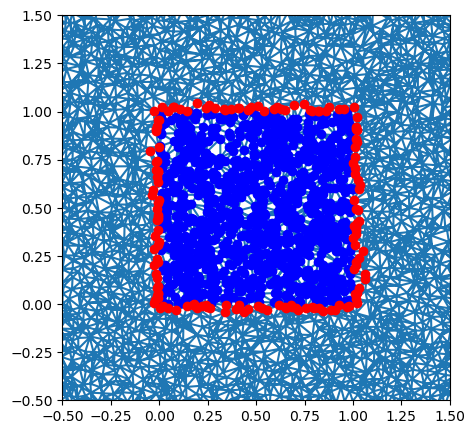

num Vs = 1242


In [307]:
# np.random.seed(0)
g = Delaunay_Torus(10000, figsize=5, plot_V_num=False)
print(f"num Vs = {g.num_Vs}")

In [353]:
half_num_fourier_modes_per_dim = 6#int(calculate_K(g.num_Vs))
print(half_num_fourier_modes_per_dim)
alpha_bulk, alpha_boundary, fourier_coefficients, F_1, F_2 = direct_solve_alpha(g, half_num_fourier_modes_per_dim, regularization=True)

6
Doing regularized solve
err = 4.181145031392514e-10


In [354]:
alpha = np.vstack((alpha_bulk, alpha_boundary))
Q = np.zeros((2, 2))
T = 0

for v, w in zip(*g.wadjacency_matrix.nonzero()):
    if v < g.num_bulk_Vs:
        
        l_vw = 1 / g.wadjacency_matrix[v, w]
        r_xy = g.v_to_X(g.V_coords[w]) - g.v_to_X(g.V_coords[v])

        q = np.tensordot(r_xy + alpha[w] - alpha[v], r_xy + alpha[w] - alpha[v], axes=0) / l_vw
        t = l_vw

        T += t 
        Q += q

print(Q / T)
# print((Q / tr) / (0.93 / 2))
# print()

[[20.31546567  0.0454798 ]
 [ 0.0454798  15.9840431 ]]


In [355]:
cc = np.abs(fourier_coefficients)
cx, cy = cc[:, 0].copy(), cc[:, 1].copy()
power_x, power_y = np.linalg.norm(cx), np.linalg.norm(cy)
cx[cx < 0.03] = 0
cy[cy < 0.03] = 0
cx *= power_x / np.linalg.norm(cx)
cy *= power_y / np.linalg.norm(cy)

new_fourier_coefficients = np.array((cx, cy)).T

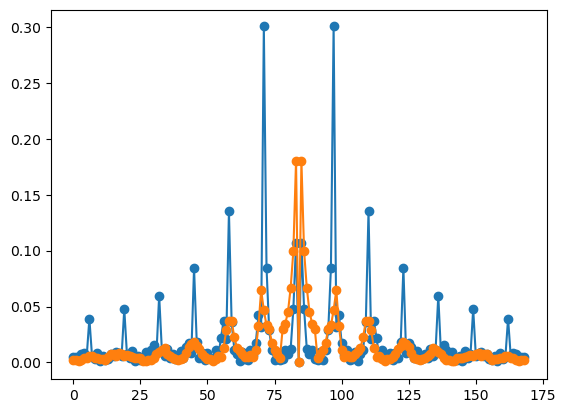

In [356]:
plt.plot(cc[:, 0], 'o-')
plt.plot(cc[:, 1], 'o-')
plt.show()

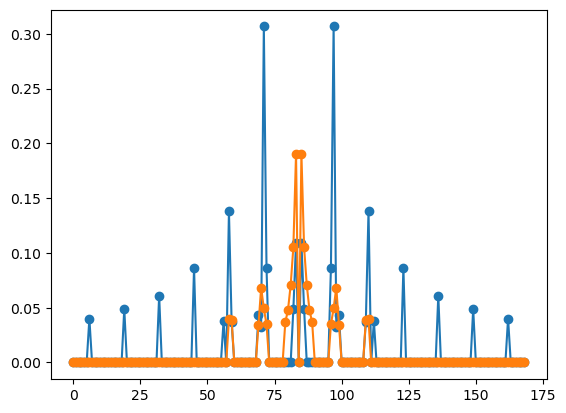

In [357]:
plt.plot(new_fourier_coefficients[:, 0], 'o-')
plt.plot(new_fourier_coefficients[:, 1], 'o-')
plt.show()

In [358]:
new_alpha_bulk = F_1 @ new_fourier_coefficients
new_alpha_boundary = F_2 @ new_fourier_coefficients

alpha = np.vstack((new_alpha_bulk, new_alpha_boundary)).real
Q = np.zeros((2, 2))
T = 0

for v, w in zip(*g.wadjacency_matrix.nonzero()):
    if v < g.num_bulk_Vs:
        
        l_vw = 1 / g.wadjacency_matrix[v, w]
        r_xy = g.v_to_X(g.V_coords[w]) - g.v_to_X(g.V_coords[v])

        q = np.tensordot(r_xy + alpha[w] - alpha[v], r_xy + alpha[w] - alpha[v], axes=0) / l_vw
        t = l_vw

        T += t 
        Q += q

print(Q / T)
# print((Q / tr) / (0.93 / 2))
# print()

[[37.67736658  3.91963597]
 [ 3.91963597 28.21764634]]


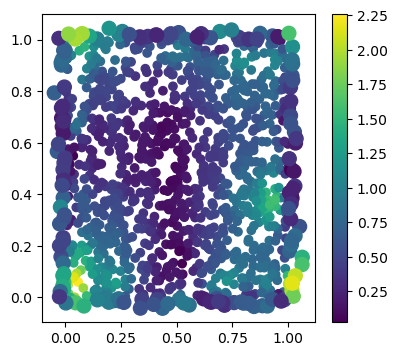

In [360]:
figsize = 4
fig = plt.figure(figsize=(1.1 * figsize, figsize))
ax = fig.add_subplot(111)

all_norms = np.concatenate([np.linalg.norm(alpha_bulk, axis=1), np.linalg.norm(alpha_boundary, axis=1)])
norm = matplotlib.colors.Normalize(vmin=np.min(all_norms), vmax=np.max(all_norms))

scatter0 = ax.scatter(g.V_coords[:g.num_bulk_Vs, 0], g.V_coords[:g.num_bulk_Vs, 1], 
                      c=np.linalg.norm(alpha_bulk, axis=1), norm=norm)
scatter1 = ax.scatter(g.V_coords[g.num_bulk_Vs:, 0], g.V_coords[g.num_bulk_Vs:, 1], 
                      c=np.linalg.norm(alpha_boundary, axis=1), s=100, norm=norm)

fig.colorbar(scatter1, ax=ax)

plt.show()

## Truncated square


|V| = 256


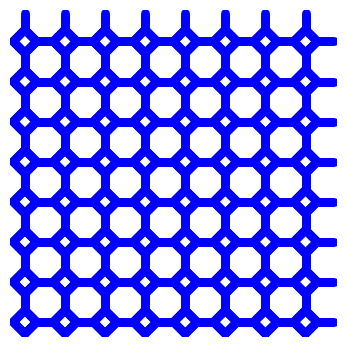

In [536]:
g = construct_graph.tiling.Tiling(tile_type="truncated_square", 
                                  num_horizontal_displacements=8, 
                                  num_vertical_displacements=8,
                                  figsize=4)

In [537]:
bulk_to_boundary_V_num = np.unique(list(g.periodic_edges.keys()))
old_to_new = {j: i + g.num_Vs for i, j in enumerate(bulk_to_boundary_V_num)}

boundary_V_map = {}
mapped = {}

for v, w in g.periodic_edges:

    vw_coords = g.periodic_edges[v, w]
    translated_ind = np.where(~((vw_coords > 0) & (vw_coords < 1)))[0][0]
    if translated_ind == 0: translated_coord_num = v
    else: translated_coord_num = w
    v_coords = g.periodic_edges[v, w][0]
    w_coords = g.periodic_edges[v, w][1]

    if translated_coord_num == v:
        mapped[w, old_to_new[v]] = np.array((w_coords, v_coords))
        translation = v_coords - (v_coords % 1)
        mapped[v, old_to_new[w]] = np.array((v_coords - translation, w_coords - translation))
        boundary_V_map[old_to_new[v]] = v_coords
        boundary_V_map[old_to_new[w]] = w_coords - translation
    else:
        mapped[v, old_to_new[w]] = np.array(v_coords, w_coords)
        translation = w_coords - (w_coords % 1)
        mapped[w, old_to_new[v]] = np.array(w_coords - translation, v_coords - translation)
        boundary_V_map[old_to_new[w]] = w_coords
        boundary_V_map[old_to_new[v]] = v_coords - translation

boundary_V_coords = []
for i in bulk_to_boundary_V_num:
    boundary_V_coords.append(boundary_V_map[old_to_new[i]])

boundary_V_coords = np.array(boundary_V_coords)
boundary_edges = np.array(list(mapped.keys()))
V_coords = np.vstack((g.V_coords, boundary_V_coords))
edges = []

for v, w in zip(*g.wadjacency_matrix.nonzero()):
    if v < w:
        if ((v, w) not in g.periodic_edges) and ((w, v) not in g.periodic_edges):
            edges.append([v, w])
edges = np.array(edges)
edges = np.vstack((edges, boundary_edges))

wadjacency_matrix = scipy.sparse.lil_matrix((np.shape(V_coords)[0], np.shape(V_coords)[0]))
for v, w in edges:
    l_vw = np.linalg.norm(V_coords[v] - V_coords[w])
    wadjacency_matrix[v, w] = 1 / l_vw
    wadjacency_matrix[w, v] = 1 / l_vw

wlaplacian = np.diag(np.sum(wadjacency_matrix.A, axis=0)) - wadjacency_matrix

def v_to_X(v):
    X = []
    for i in range(2):
        if v[i] < 0: X.append(-0.5)
        elif v[i] < 1: X.append(0.5)
        else: X.append(1.5)
    return np.array(X)

r = np.zeros((g.num_Vs, 2))
for v, w in zip(*wadjacency_matrix.nonzero()):
    if v < g.num_Vs:
        l_vw = 1 / wadjacency_matrix[v, w]
        r[v] += (v_to_X(V_coords[w]) - v_to_X(V_coords[v])) / l_vw

class Custom_Graph:

    def __init__(self, V_coords, wlaplacian, num_bulk_Vs, r, perturb=False, fac=0.0):

        self.V_coords = V_coords
        self.wlaplacian = wlaplacian
        self.num_bulk_Vs = num_bulk_Vs
        self.r = r

        if perturb:
            self.perturb_V_coords(fac=fac)

    def perturb_V_coords(self, fac=0.0):

        l = np.linalg.norm(self.V_coords[0] - self.V_coords[self.wlaplacian[0].nonzero()[1][1]])
        self.V_coords = self.V_coords + np.random.uniform(-fac * l, fac * l, size=self.V_coords.shape)
        for v, w in zip(*self.wlaplacian.nonzero()):
            if v != w:
                ell = np.linalg.norm(self.V_coords[v] - self.V_coords[w]) 
                self.wlaplacian[v, w] = 1 / ell
        self.wlaplacian = np.array(np.diag(np.sum(self.wlaplacian.A, axis=0)) - self.wlaplacian)

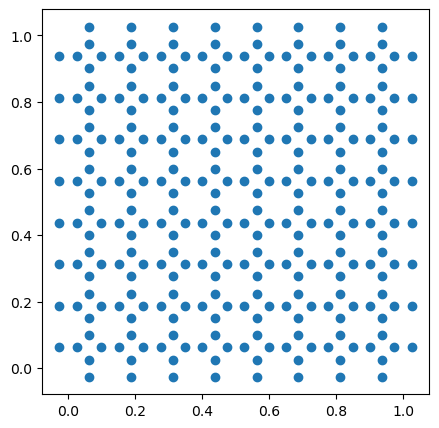

In [538]:
cg = Custom_Graph(V_coords, wlaplacian, g.num_Vs, r, perturb=True, fac=0.0)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.scatter(cg.V_coords[:, 0], cg.V_coords[:, 1])
plt.show()

In [539]:
half_num_fourier_modes_per_dim = int(calculate_K(g.num_Vs))
print(half_num_fourier_modes_per_dim)
alpha_bulk, alpha_boundary, fourier_coefficients, F_1, F_2 = direct_solve_alpha(cg, half_num_fourier_modes_per_dim, regularization=False)

8
Doing least squares
err = 17.25538598241725


In [528]:
truncated_fourier_coefficients = fourier_coefficients.copy()

truncate = 140

# truncated_fourier_coefficients[truncate:-truncate] = 0
# # truncated_fourier_coefficients[:truncate] = 0
# # truncated_fourier_coefficients[-truncate:] = 0

truncated_alpha_bulk = (F_1 @ truncated_fourier_coefficients).real
truncated_alpha_boundary = (F_2 @ truncated_fourier_coefficients).real

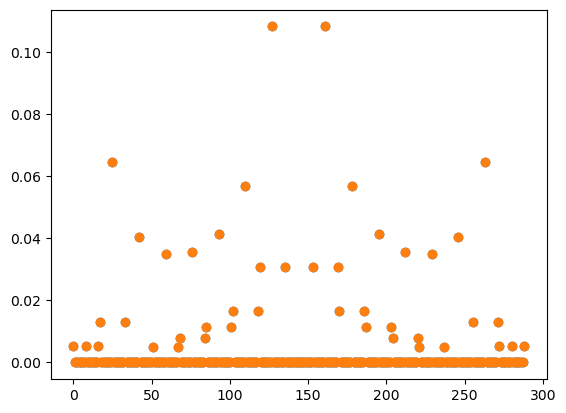

In [532]:
plt.plot(np.abs(fourier_coefficients[:, 0]), 'o')
plt.plot(np.abs(truncated_fourier_coefficients[:, 0]), 'o')

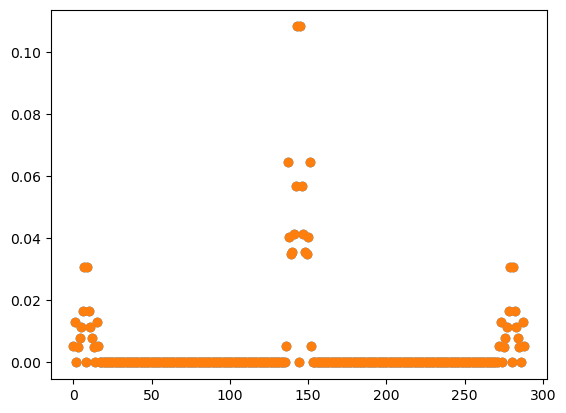

In [531]:
plt.plot(np.abs(fourier_coefficients[:, 1]), 'o')
plt.plot(np.abs(truncated_fourier_coefficients[:, 1]), 'o')

In [523]:
# alpha = np.vstack((alpha_bulk, alpha_boundary))
alpha = np.vstack((alpha_bulk, truncated_alpha_boundary))
Q = np.zeros((2, 2))
tr = 0

for v, w in zip(*wadjacency_matrix.nonzero()):
    if v < cg.num_bulk_Vs:
        l_vw = 1 / wadjacency_matrix[v, w]
        tr += l_vw
        r_xy = v_to_X(cg.V_coords[w]) - v_to_X(cg.V_coords[v])
        Q += np.tensordot(r_xy + alpha[w] - alpha[v], r_xy + alpha[w] - alpha[v], axes=0) / l_vw

print("Q / tr =")
print(Q / tr)

c = (1 + np.sqrt(2))**2 / 12
print("\nrel_err = ")
print(((Q / tr)  - c*np.eye(2)) / c)
print()

Q / tr =
[[ 4.85702260e-01 -4.77431195e-16]
 [-4.77431195e-16  2.67607160e+00]]

rel_err = 
[[-1.25719543e-14 -9.82970915e-16]
 [-9.82970915e-16  4.50969558e+00]]



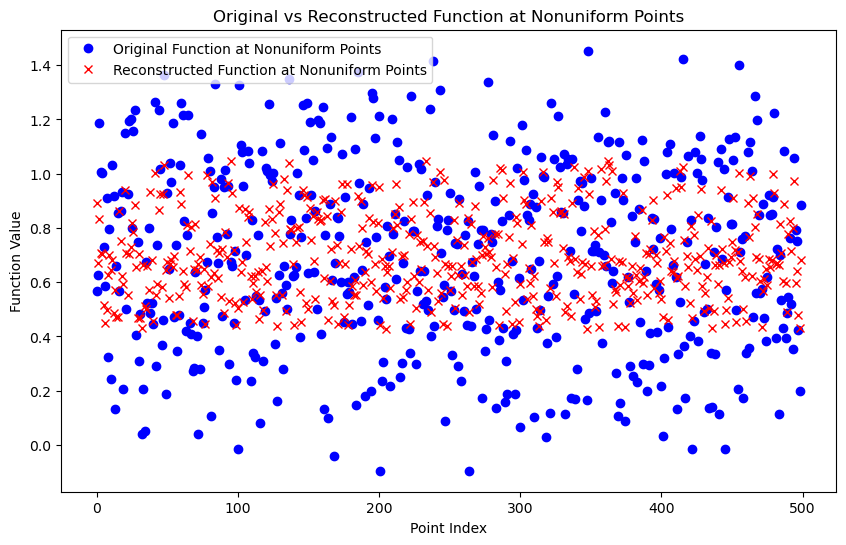

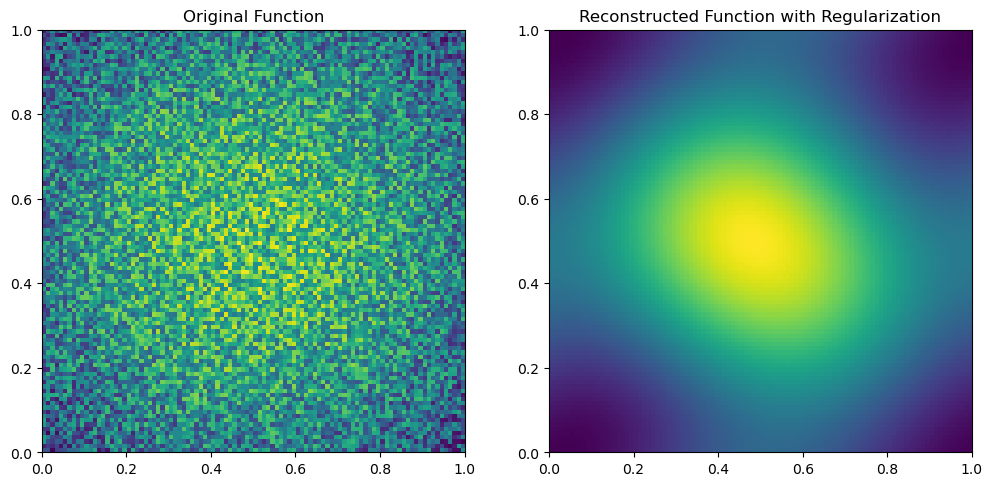

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

# Define the function we want to interpolate
def f(x, y):
    return np.cos(2 * np.pi * (x + 1) / 3) * np.cos(2 * np.pi * (y + 1) / 3) + 0.5 * np.random.uniform(-1, 1, size=x.shape)

# Generate nonuniform points in the unit square
np.random.seed(42)
n_points = 500
x_nonuniform = np.random.rand(n_points)
y_nonuniform = np.random.rand(n_points)

# Evaluate the function at these points
z_nonuniform = f(x_nonuniform, y_nonuniform)

# Define Fourier modes (up to n/2 positive and negative frequencies)
num_modes = 1  # Number of modes in each direction (you can adjust this)
modes_x = np.arange(-num_modes, num_modes + 1)
modes_y = np.arange(-num_modes, num_modes + 1)

# Create the design matrix for least squares (nonuniform trigonometric basis)
G = np.zeros((n_points, (2 * num_modes + 1) ** 2), dtype=complex)

# Fill the design matrix with appropriate trigonometric terms
index = 0
for mx in modes_x:
    for my in modes_y:
        G[:, index] = np.exp(1j * 2 * np.pi * (x_nonuniform * mx + y_nonuniform * my))
        index += 1

# Regularization parameter (small positive value)
lambda_reg = 1e-3

# Modify the system of equations for Tikhonov regularization
A = G.conj().T @ G + lambda_reg * np.eye(G.shape[1])
b = G.conj().T @ z_nonuniform

# Solve the regularized least squares problem using 'solve'
coefficients = solve(A, b)

# Reconstruct the function back onto the original nonuniform points using matrix multiplication
reconstruction_nonuniform = G @ coefficients

# Plot the original function values and the reconstructed values at the nonuniform points
plt.figure(figsize=(10, 6))
plt.plot(z_nonuniform.real, 'bo', label='Original Function at Nonuniform Points')
plt.plot(reconstruction_nonuniform.real, 'rx', label='Reconstructed Function at Nonuniform Points')
plt.legend()
plt.title('Original vs Reconstructed Function at Nonuniform Points')
plt.xlabel('Point Index')
plt.ylabel('Function Value')

# Reconstruct the function at a regular grid for comparison
x_reg, y_reg = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
X_grid, Y_grid = np.meshgrid(x_reg, y_reg)
reconstruction = np.zeros_like(X_grid, dtype=complex)

# Reconstruct using the calculated Fourier coefficients
index = 0
for mx in modes_x:
    for my in modes_y:
        reconstruction += coefficients[index] * np.exp(1j * 2 * np.pi * (X_grid * mx + Y_grid * my))
        index += 1

# Plot the original function and the reconstruction
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original function
Z_original = f(X_grid, Y_grid)
ax[0].imshow(np.real(Z_original), extent=[0, 1, 0, 1], origin='lower')
ax[0].set_title('Original Function')

# Reconstructed function
ax[1].imshow(np.real(reconstruction), extent=[0, 1, 0, 1], origin='lower')
ax[1].set_title('Reconstructed Function with Regularization')

plt.show()

In [138]:
A @ coefficients - b

array([0.00000000e+00+1.77635684e-15j, 3.55271368e-15+1.77635684e-15j,
       0.00000000e+00-3.55271368e-15j, 0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+2.83993887e-16j, 7.10542736e-15+3.55271368e-15j,
       1.77635684e-15-3.55271368e-15j, 1.06581410e-14+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j])

In [117]:
# Generate nonuniform points in the unit square
np.random.seed(0)
new_n_points = 2
new_x_nonuniform = np.random.rand(new_n_points)
new_y_nonuniform = np.random.rand(new_n_points)

# Evaluate the function at these points
new_z_nonuniform = f(new_x_nonuniform, new_y_nonuniform)

print(new_x_nonuniform, new_y_nonuniform)
print(new_z_nonuniform)

[0.5488135  0.71518937] [0.60276338 0.54488318]
[0.89548176 1.04206602]


In [118]:
# Create the design matrix for least squares (nonuniform trigonometric basis)
new_G = np.zeros((new_n_points, (2 * num_modes + 1) ** 2), dtype=complex)

# Fill the design matrix with appropriate trigonometric terms
index = 0
for mx in modes_x:
    for my in modes_y:
        new_G[:, index] = np.exp(1j * 2 * np.pi * (new_x_nonuniform * mx + new_y_nonuniform * my))
        index += 1

print(new_G @ coefficients)

[0.9074131 -7.91380017e-17j 0.69555534+1.64145436e-16j]


In [11]:
ell = 1 / (2 * (1 + np.sqrt(2)))
a1 = np.array([1, 0])  
a2 = np.array([0, 1]) 

bulk_edges = np.array((
    [0, 1], [1, 2], [2, 3], [3, 0],   
    [4, 5], [5, 6], [6, 7], [7, 4],
    [8, 9], [9, 10], [10, 11], [11, 8],
    [12, 13], [13, 14], [14, 15], [15, 12],
    [1, 11], [5, 15], [2, 4], [10, 12]))

boundary_edges = np.array(([0, 16], [3, 17], [6, 18], [7, 19], [8, 20], [9, 21], [13, 22], [14, 23]))

edges = np.vstack((bulk_edges, boundary_edges))

adjacency_matrix = np.zeros((24, 24))
for v, w in edges:
    adjacency_matrix[v, w] = -1 / ell
    adjacency_matrix[w, v] = -1 / ell

A = adjacency_matrix - np.diag(np.sum(adjacency_matrix, axis=0)) 

bulk_points = g.V_coords.copy()
boundary_points = np.array((bulk_points[6] - a1, 
                            bulk_points[9] - a2,
                            bulk_points[0] + a1,
                            bulk_points[13] - a2,
                            bulk_points[14] - a1,
                            bulk_points[3] + a2,
                            bulk_points[7] + a2,
                            bulk_points[8] + a1))

points = np.vstack((bulk_points, boundary_points))

d_bulk = np.array([
    [-1, 0],
    [0, 0],
    [0, 0],
    [0, -1],
    [0, 0],
    [0, 0],
    [1, 0],
    [0, -1],
    [-1, 0],
    [0, 1],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 1],
    [1, 0],
    [0, 0]
]) / ell

# d_boundary = np.zeros((8, 2))
# d = np.vstack((d_bulk, d_boundary))

N = 24
n = 8
N_n = N - n
K = 4
points_f1 = bulk_points.copy()
points_f2 = boundary_points.copy()

L = A[:N_n, :N_n] #/ ell 
B = A[:N_n, N_n:] #/ ell 
I = np.eye(N_n)         
r = d_bulk[:N_n] #/ ell     

g = Custom_Graph(points, A, N_n, r)

In [12]:
alpha_bulk, alpha_boundary = solve_alpha(g, 16)

alpha = np.vstack((alpha_bulk, alpha_boundary))

Doing least squares
err = 4.592117444015196e-13


In [15]:
Q = np.zeros((2, 2))
tr = 0

vs, ws = adjacency_matrix.nonzero()
for v, w in zip(vs, ws):
    if v < N_n:
        tr += 1
        if w < N - n:
            Q += np.tensordot(alpha[w] - alpha[v], alpha[w] - alpha[v], axes=0) / ell
        else:
            Q += np.tensordot(r[v] * ell + alpha[w] - alpha[v], r[v] * ell + alpha[w] - alpha[v], axes=0) / ell

tr *= ell

print(Q / tr)
print()
c = (1 + np.sqrt(2))**2 / 12
print(c)

[[ 4.85702260e-01 -8.55606958e-15]
 [-8.55606958e-15  4.85702260e-01]]

0.48570226039551584


## Fourier interpolation

In [313]:
import numpy as np
from pynufft import NUFFT

# Define the number of nonuniform sample points
N = 16

# Define the nonuniform sample points (x_n, y_n)
x_n = np.random.rand(N)
y_n = np.random.rand(N)
positions = np.column_stack((x_n, y_n))

# Define the scalar function values at these points f(x, y) = sin(2*pi*x) + cos(2*pi*y)
f = np.sin(2 * np.pi * x_n) + np.cos(2 * np.pi * y_n)

# Set up the NUFFT object for a 2D transform
nufft = NUFFT()

# Initialize the NUFFT with the nonuniform points and the desired output grid
Nd = (N, N)  # size of the grid in the output domain
Kd = (2*N, 2*N)  # size of the oversampled grid (for accuracy)
Jd = (6, 6)  # size of the interpolation kernel

# Plan the NUFFT
nufft.plan(positions, Nd, Kd, Jd)

# Perform the forward NUFFT for the scalar function f(x, y)
F = nufft.forward(f)

# Use the inverse NUFFT (adjoint) to reconstruct the function at the nonuniform points
f_reconstructed = nufft.adjoint(F)

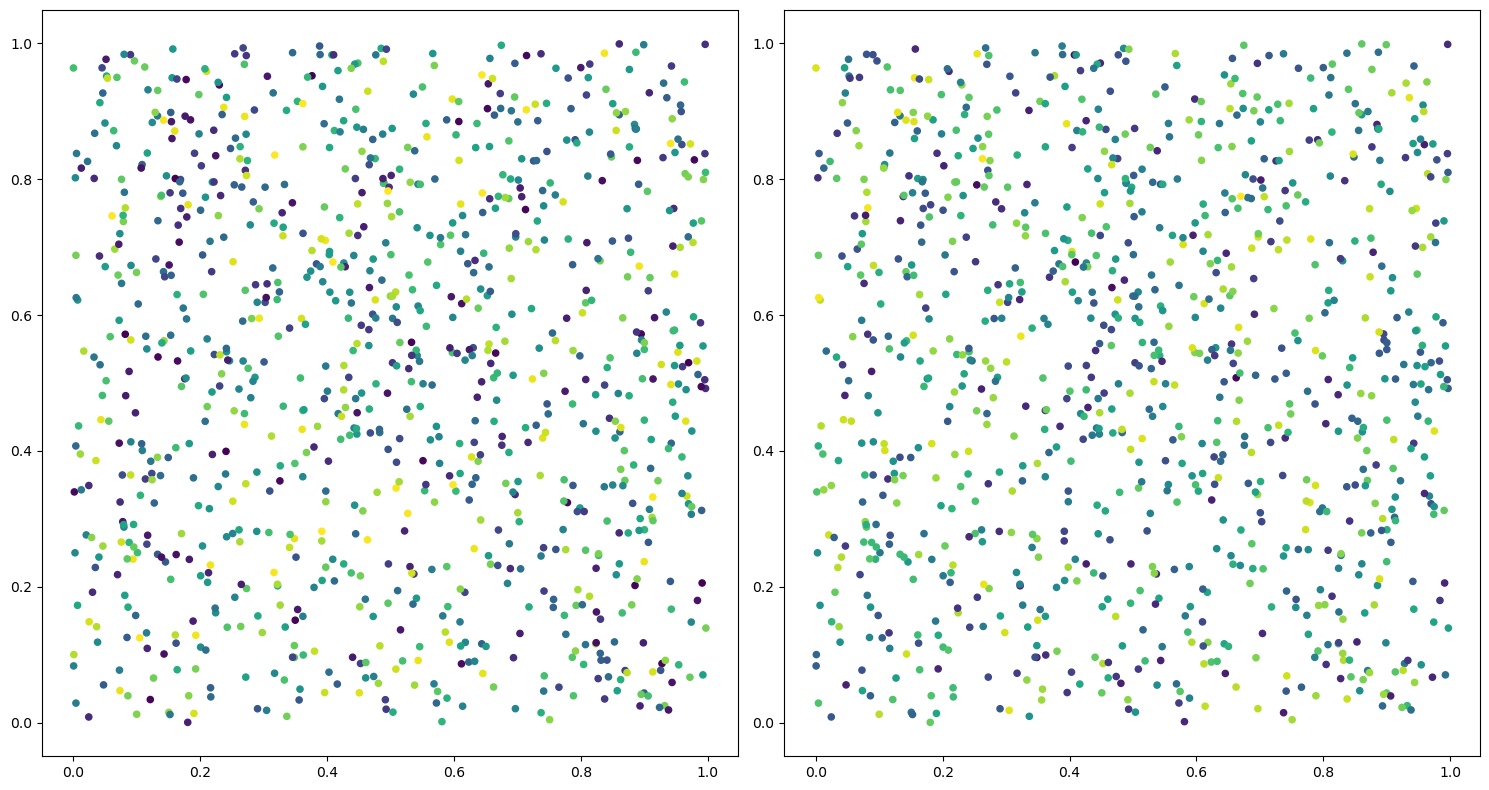

In [864]:
def calculate_num_modes(N):
    K = 0
    prod = 0
    while prod < N:
        K += 1
        prod = (2 * K + 1)**2
    return K

def original_function(x, y, m=20, n=20):
    func = np.sin(2 * np.pi * x * m) * np.cos(2 * np.pi * y * n)
    noise = np.random.uniform(-1, 1, size=func.shape)
    return noise

# Generate arbitrary points in the unit square
N = 1000
# np.random.seed(0)
x_points = np.random.rand(N)
y_points = np.random.rand(N)
f_values = original_function(x_points, y_points)

# Define bandwidth (K1, K2) for the Fourier series
K1 = K2 = int(calculate_num_modes(N))  # Adjust bandwidth as necessary

# Construct the Fourier matrix
def construct_fourier_matrix(N, x, y, K1, K2):
    matrix = np.zeros((N, (2 * K1 + 1) * (2 * K2 + 1)), dtype=complex)
    idx = 0
    for k1 in range(-K1, K1 + 1):
        for k2 in range(-K2, K2 + 1):
            matrix[:, idx] = np.exp(2j * np.pi * (k1 * x + k2 * y))
            idx += 1
    return matrix

# Construct the Fourier matrix for the arbitrary points
F = construct_fourier_matrix(N, x_points, y_points, K1, K2)

# Solve the least squares problem to find the Fourier coefficients
coefficients, _, _, _ = np.linalg.lstsq(F, f_values, rcond=None)

# Define the interpolant function
def interpolant(x, y, coefficients, K1, K2):
    interp_value = np.zeros_like(x, dtype=complex)
    idx = 0
    for k1 in range(-K1, K1 + 1):
        for k2 in range(-K2, K2 + 1):
            interp_value += coefficients[idx] * np.exp(2j * np.pi * (k1 * x + k2 * y))
            idx += 1
    return np.real(interp_value)

# X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
f_grid = original_function(x_points, y_points)
f_interp_grid = interpolant(x_points, y_points, coefficients, K1, K2)

# Plot the original function, interpolated function, and difference
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].scatter(x_points, y_points, c=f_grid.flatten(), s=20)
axs[1].scatter(x_points, y_points, c=f_interp_grid.flatten(), s=20)

plt.tight_layout()
plt.show()


In [867]:
np.linalg.norm(f_grid - f_interp_grid) / np.linalg.norm(f_grid)

1.4300982045292359